# Prueba Banco Caja Social:

In [1]:
library(data.table)

In [2]:
BASE = fread("D:/2020_1/work_caja_social/Base_Prueba_1.csv",data.table = F) 


### Matriz_Trancision 

In [3]:
table(BASE$Mora_Inicial,BASE$Mora_Siguiente) / nrow(BASE)


      
                  0            1            2            3
  0    0.7460106873 0.1462318039 0.0002211166 0.0000000000
  1    0.0200110558 0.0355629261 0.0102082182 0.0002948222
  2    0.0013635526 0.0025059886 0.0055279160 0.0107610098
  NULL 0.0208586696 0.0003316750 0.0001105583 0.0000000000

<br>

Dado que hay mas casos que pasan de estar bien a una altura de mora 1, a comparacion de casos que de estar en una altura de mora 1 se recuperan.

Se establece que el limite del BGI debe ser una altura de mora igual o mayor a  1, la metodologia establecida es una matriz de transicion.

### Analisis descriptivo, exploratorio:


Este analisis fue realizado en PowerBi, por tal razon se debe ingresar a este [link](https://app.powerbi.com/view?r=eyJrIjoiNTFjNmE1MGItZjdhZC00ZTQ3LWFlOTYtMTliZWViZDc3YjQ1IiwidCI6IjcxOGE2MTYzLWE5YzYtNDdlMi1iYzRjLTZmMjRmMGJjMjYyYyJ9), para poder visualizar el resultado,

In [10]:
library(h2o)

In [12]:
BASE$BGI = ifelse(BASE$Mora_Inicial>=1,1,0 )

In [13]:

h2o.init(max_mem_size = "10G",nthreads=-1)


H2O is not running yet, starting it now...

Note:  In case of errors look at the following log files:
    C:\Users\ASUS\AppData\Local\Temp\RtmpA383IQ\file36845ce27d77/h2o_ASUS_started_from_r.out
    C:\Users\ASUS\AppData\Local\Temp\RtmpA383IQ\file3684398b3d09/h2o_ASUS_started_from_r.err


Starting H2O JVM and connecting: . Connection successful!

R is connected to the H2O cluster: 
    H2O cluster uptime:         6 seconds 982 milliseconds 
    H2O cluster timezone:       America/Bogota 
    H2O data parsing timezone:  UTC 
    H2O cluster version:        3.30.0.1 
    H2O cluster version age:    6 months and 3 days !!! 
    H2O cluster name:           H2O_started_from_R_ASUS_zgt243 
    H2O cluster total nodes:    1 
    H2O cluster total memory:   8.89 GB 
    H2O cluster total cores:    8 
    H2O cluster allowed cores:  8 
    H2O cluster healthy:        TRUE 
    H2O Connection ip:          localhost 
    H2O Connection port:        54321 
    H2O Connection proxy:       NA 
    

Warning message in h2o.clusterInfo():
"
Your H2O cluster version is too old (6 months and 3 days)!
Please download and install the latest version from http://h2o.ai/download/"

In [68]:
DATA_1 =  h2o.importFile(path = "D:/2020_1/work_caja_social/Base_Prueba_2.csv")

  |======================================================================| 100%


In [69]:
DATA_1 = DATA_1[-1,]

In [70]:
DATA_1$BGI = as.factor(as.character(DATA_1$BGI))

In [71]:
splits <- h2o.splitFrame(data=DATA_1, ratios=c(0.7,0.2))  
train <- splits[[1]]
valid <- splits[[2]]
test <- splits[[3]]

In [72]:
target <- "BGI"

predictors <- c( "Producto"              ,          "Cuotas_Pagadas"    ,             
  "Cuotas_Pactadas"       ,          "OCUPACION"   ,                   
  "Perspectiva_Sectorial"  ,         "Mono/Multi"   ,                  
  "Antiguedad_Cliente"      ,        "Antiguedad_Obligacion"  ,        
"Valor_Desembolso"          ,      "Actividad_Economica",            
"Ciudad"      ,                    "Oficina"     ,                   
 "Regional" ,            
"Contador_Pagos_6MesesAnteriores", "Nivel_Riesgo","Saldo_Capital") 


In [73]:
GBM_MODEL <- h2o.gbm(x = predictors,
                    y = target,
                    nfolds = 2,
                    seed = 1111,
                    keep_cross_validation_predictions = TRUE,
                    training_frame = train)

  |======================================================================| 100%


In [74]:
perf <- h2o.performance(GBM_MODEL, test)
perf

H2OBinomialMetrics: gbm

MSE:  0.07915458
RMSE:  0.2813442
LogLoss:  0.2788743
Mean Per-Class Error:  0.2839703
AUC:  0.8042388
AUCPR:  0.3681611
Gini:  0.6084775
R^2:  0.1515925

Confusion Matrix (vertical: actual; across: predicted) for F1-optimal threshold:
          0   1    Error       Rate
0      2191 252 0.103152  =252/2443
1       132 152 0.464789   =132/284
Totals 2323 404 0.140814  =384/2727

Maximum Metrics: Maximum metrics at their respective thresholds
                        metric threshold       value idx
1                       max f1  0.221001    0.441860 198
2                       max f2  0.120143    0.544470 257
3                 max f0point5  0.444763    0.440871 105
4                 max accuracy  0.656923    0.901357  45
5                max precision  0.688149    0.615385  37
6                   max recall  0.002768    1.000000 399
7              max specificity  0.953516    0.999591   0
8             max absolute_mcc  0.180880    0.372194 217
9   max min_per_c

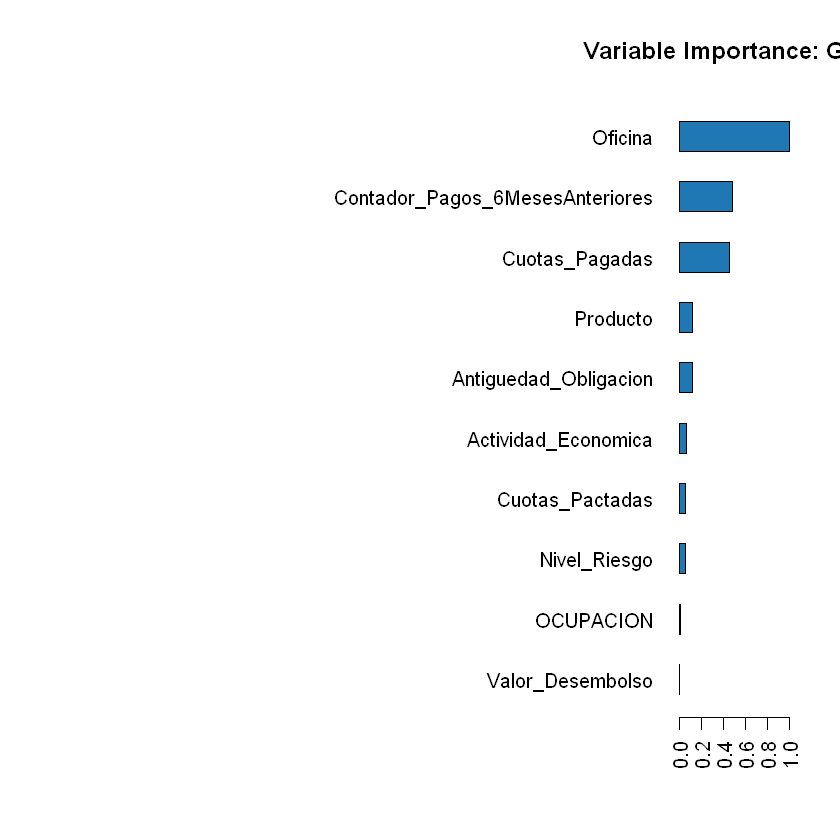

In [77]:
h2o.varimp_plot(GBM_MODEL)

 Lo que indica el modelo, es que para detectar que personas pueden caer potencialmente en mora y quienes no. Las variables que mas utiliza el modelo son:

* Oficina
* Contador_Pagos_6MesesAnteriores
* Cuotas Pagadas
* Producto 
* Antiguedad Obligacion.

### Segmentacion:

La segmentacion se va a hacer en base a lo que indique los ALE_PLOTS de este algoritmo sobre las variables que son mas importantes para el.



In [79]:
defaultW <- getOption("warn") 

library(dplyr)
library(iml)
library(DALEX)
library(TeachingSampling)

# 2. Create a vector with the actual responses
response <- as.numeric(as.vector(DATA_1$BGI))

# 3. Create custom predict function that returns the predicted values as a
#    vector (probability of purchasing in our example)
pred <- function(model, newdata)  {
  results <- as.data.frame(h2o.predict(model, as.h2o(newdata)))
  return(results[[3L]])
}

In [84]:
table(as.vector(DATA_1$BGI))

## Sample:
Nh = c(24217,2918)
nh <- c(2400,300)

res<-S.STSI(BASE$BGI, Nh, nh)

DATA_SAM = BASE[res,]

response_1 <- as.numeric(as.vector(BASE$BGI))


    0     1 
24217  2918 

In [85]:
predictor.gbm <- Predictor$new(
  model = GBM_MODEL, 
  data = DATA_SAM, 
  y = target, 
  predict.fun = pred,
  class = "classification"
)

### Oficinas:

In [87]:

## Ale plots:

aggregate(BASE$BGI,by=list(BASE$Oficina),mean)

Warning message in mean.default(X[[i]], ...):
"argument is not numeric or logical: returning NA"Warning message in mean.default(X[[i]], ...):
"argument is not numeric or logical: returning NA"Warning message in mean.default(X[[i]], ...):
"argument is not numeric or logical: returning NA"Warning message in mean.default(X[[i]], ...):
"argument is not numeric or logical: returning NA"Warning message in mean.default(X[[i]], ...):
"argument is not numeric or logical: returning NA"Warning message in mean.default(X[[i]], ...):
"argument is not numeric or logical: returning NA"Warning message in mean.default(X[[i]], ...):
"argument is not numeric or logical: returning NA"Warning message in mean.default(X[[i]], ...):
"argument is not numeric or logical: returning NA"Warning message in mean.default(X[[i]], ...):
"argument is not numeric or logical: returning NA"Warning message in mean.default(X[[i]], ...):
"argument is not numeric or logical: returning NA"Warning message in mean.default(X[[i]], 

"argument is not numeric or logical: returning NA"Warning message in mean.default(X[[i]], ...):
"argument is not numeric or logical: returning NA"Warning message in mean.default(X[[i]], ...):
"argument is not numeric or logical: returning NA"Warning message in mean.default(X[[i]], ...):
"argument is not numeric or logical: returning NA"Warning message in mean.default(X[[i]], ...):
"argument is not numeric or logical: returning NA"Warning message in mean.default(X[[i]], ...):
"argument is not numeric or logical: returning NA"Warning message in mean.default(X[[i]], ...):
"argument is not numeric or logical: returning NA"Warning message in mean.default(X[[i]], ...):
"argument is not numeric or logical: returning NA"Warning message in mean.default(X[[i]], ...):
"argument is not numeric or logical: returning NA"Warning message in mean.default(X[[i]], ...):
"argument is not numeric or logical: returning NA"Warning message in mean.default(X[[i]], ...):
"argument is not numeric or logical: ret

"argument is not numeric or logical: returning NA"Warning message in mean.default(X[[i]], ...):
"argument is not numeric or logical: returning NA"Warning message in mean.default(X[[i]], ...):
"argument is not numeric or logical: returning NA"Warning message in mean.default(X[[i]], ...):
"argument is not numeric or logical: returning NA"Warning message in mean.default(X[[i]], ...):
"argument is not numeric or logical: returning NA"Warning message in mean.default(X[[i]], ...):
"argument is not numeric or logical: returning NA"Warning message in mean.default(X[[i]], ...):
"argument is not numeric or logical: returning NA"Warning message in mean.default(X[[i]], ...):
"argument is not numeric or logical: returning NA"Warning message in mean.default(X[[i]], ...):
"argument is not numeric or logical: returning NA"Warning message in mean.default(X[[i]], ...):
"argument is not numeric or logical: returning NA"Warning message in mean.default(X[[i]], ...):
"argument is not numeric or logical: ret

"argument is not numeric or logical: returning NA"Warning message in mean.default(X[[i]], ...):
"argument is not numeric or logical: returning NA"Warning message in mean.default(X[[i]], ...):
"argument is not numeric or logical: returning NA"Warning message in mean.default(X[[i]], ...):
"argument is not numeric or logical: returning NA"Warning message in mean.default(X[[i]], ...):
"argument is not numeric or logical: returning NA"Warning message in mean.default(X[[i]], ...):
"argument is not numeric or logical: returning NA"Warning message in mean.default(X[[i]], ...):
"argument is not numeric or logical: returning NA"Warning message in mean.default(X[[i]], ...):
"argument is not numeric or logical: returning NA"Warning message in mean.default(X[[i]], ...):
"argument is not numeric or logical: returning NA"Warning message in mean.default(X[[i]], ...):
"argument is not numeric or logical: returning NA"Warning message in mean.default(X[[i]], ...):
"argument is not numeric or logical: ret

Group.1,x
<chr>,<dbl>
Acacias,NA
Alamos,NA
Alcazares,NA
Alfonso Lopez,NA
Alpujarra,NA
Altavista,NA
Alto Prado,NA
America,NA
Antiguo Country,NA


La metodologia no puede ser desarrollada dado el nivel de Missing values  en la base.